In [2]:
!pip install kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayasquallihoussaini","key":"2a0a06840c3d4f417d08028de774744f"}'}

In [3]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
#Import dataset
!kaggle datasets download -d mkashifn/nbaiot-dataset

Dataset URL: https://www.kaggle.com/datasets/mkashifn/nbaiot-dataset
License(s): unknown
100% 1.75G/1.75G [00:10<00:00, 144MB/s]
100% 1.75G/1.75G [00:10<00:00, 183MB/s]


In [5]:
!unzip nbaiot-dataset.zip -d content

Archive:  nbaiot-dataset.zip
  inflating: content/1.benign.csv    
  inflating: content/1.gafgyt.combo.csv  
  inflating: content/1.gafgyt.junk.csv  
  inflating: content/1.gafgyt.scan.csv  
  inflating: content/1.gafgyt.tcp.csv  
  inflating: content/1.gafgyt.udp.csv  
  inflating: content/1.mirai.ack.csv  
  inflating: content/1.mirai.scan.csv  
  inflating: content/1.mirai.syn.csv  
  inflating: content/1.mirai.udp.csv  
  inflating: content/1.mirai.udpplain.csv  
  inflating: content/2.benign.csv    
  inflating: content/2.gafgyt.combo.csv  
  inflating: content/2.gafgyt.junk.csv  
  inflating: content/2.gafgyt.scan.csv  
  inflating: content/2.gafgyt.tcp.csv  
  inflating: content/2.gafgyt.udp.csv  
  inflating: content/2.mirai.ack.csv  
  inflating: content/2.mirai.scan.csv  
  inflating: content/2.mirai.syn.csv  
  inflating: content/2.mirai.udp.csv  
  inflating: content/2.mirai.udpplain.csv  
  inflating: content/3.benign.csv    
  inflating: content/3.gafgyt.combo.csv  
  inf

In [6]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sea
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, make_scorer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [7]:
#Testing for only one device (5 for example)
benign = pd.read_csv('content/5.benign.csv')
combo = pd.read_csv('content/5.gafgyt.combo.csv')
junk = pd.read_csv('content/5.gafgyt.junk.csv')
g_scan = pd.read_csv('content/5.gafgyt.scan.csv')
g_tcp = pd.read_csv('content/5.gafgyt.tcp.csv')
g_udp = pd.read_csv('content/5.gafgyt.udp.csv')
m_scan = pd.read_csv('content/5.mirai.scan.csv')
m_ack = pd.read_csv('content/5.mirai.ack.csv')
m_syn = pd.read_csv('content/5.mirai.syn.csv')
m_udp = pd.read_csv('content/5.mirai.udp.csv')
m_udpplain = pd.read_csv('content/5.mirai.udpplain.csv')

In [8]:
# Attack Labels
benign['type'] = 'benign'
combo['type'] = 'gafgyt.combo'
junk['type'] = 'gafgyt.junk'
g_scan['type'] = 'gafgyt.scan'
g_tcp['type'] = 'gafgyt.tcp'
g_udp['type'] = 'gafgyt.udp'
m_scan['type'] = 'mirai.scan'
m_ack['type'] = 'mirai.ack'
m_syn['type'] = 'mirai.syn'
m_udp['type'] = 'mirai.udp'
m_udpplain['type'] = 'mirai.udpplain'

In [9]:
df = pd.concat([benign, combo, junk, g_scan, g_tcp, g_udp, m_scan, m_ack, m_syn,m_udp, m_udpplain], axis=0, ignore_index=True, sort=False)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828260 entries, 0 to 828259
Columns: 116 entries, MI_dir_L5_weight to type
dtypes: float64(115), object(1)
memory usage: 733.0+ MB


In [11]:
df["type"].value_counts()

,count
type,
mirai.udp,156248
gafgyt.tcp,104510
gafgyt.udp,104011
mirai.scan,96781
mirai.syn,65746
benign,62154
gafgyt.combo,61380
mirai.ack,60554
mirai.udpplain,56681


<Axes: title={'center': 'Class Distribution (Testing for Device 5: Camera)'}, xlabel='count', ylabel='type'>

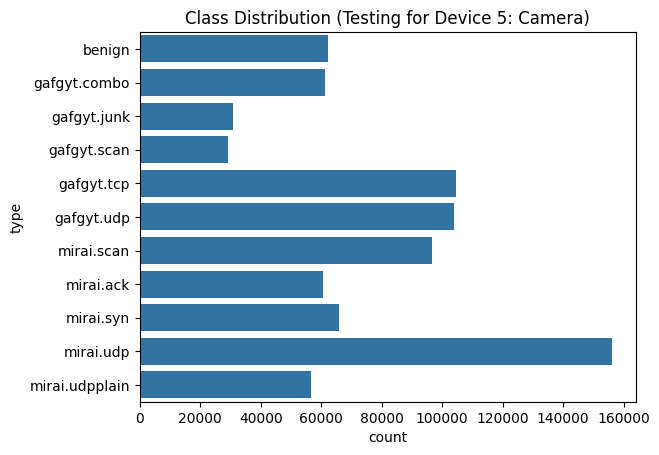

In [12]:
plt.title("Class Distribution (Testing for Device 5: Camera)")
sea.countplot(df["type"])

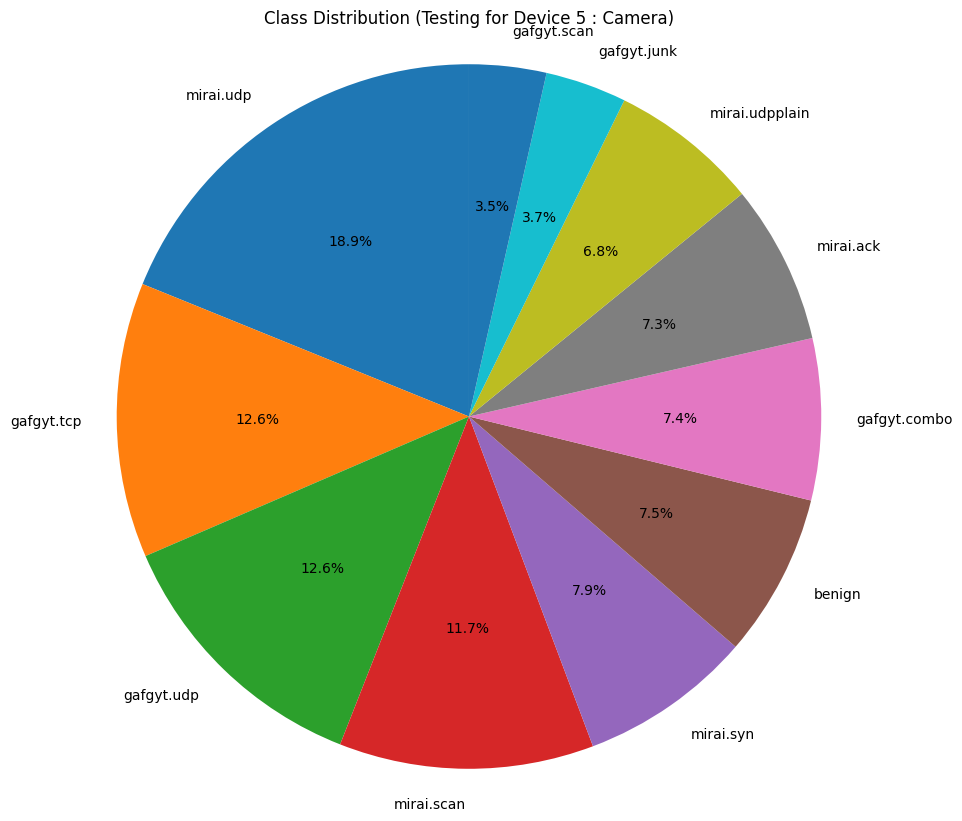

In [13]:
plt.figure(figsize=(10, 10))
plt.title("Class Distribution (Testing for Device 5 : Camera)")
df["type"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.axis('equal')
plt.show()

# PCA

Explained variance ratio (first 10): [0.32185998 0.20578342 0.13056976 0.07730792 0.07058058 0.03374117
 0.02652723 0.02511625 0.01621369 0.01225587]
Cumulative variance explained: 0.9999999999999999
PCA components kept: 115


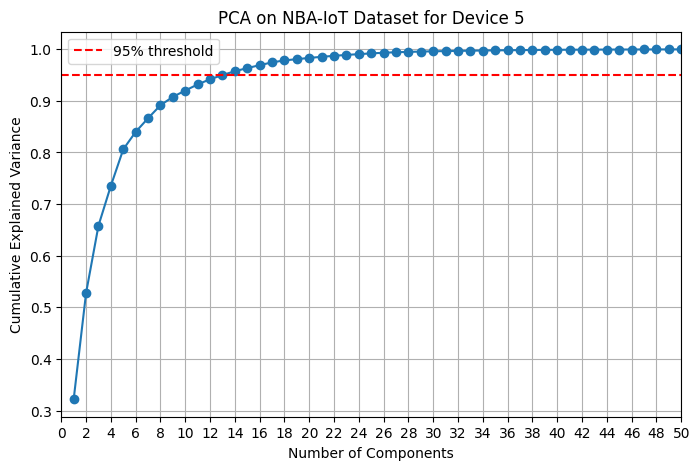

In [14]:
y = df['type']
x = df.drop(columns=['type'])

#Scale features
scaler = StandardScaler()
scaler.fit(x) # Fit only on numerical features
X = scaler.transform(x) # Transform only numerical features

pca = PCA(n_components=None, random_state=0)
X_pca = pca.fit_transform(X)

print("Explained variance ratio (first 10):", pca.explained_variance_ratio_[:10])
print("Cumulative variance explained:", pca.explained_variance_ratio_.sum())
print("PCA components kept:", X_pca.shape[1])

df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])], index=df.index)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1),
         cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% threshold")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA on NBA-IoT Dataset for Device 5")
plt.xticks(range(0, len(cumulative_variance)+1, 2))

plt.xlim([0, 50])
plt.grid()
plt.legend()
plt.show()

In [15]:
# Smallest k such that C(k) >= 95%
n_components = next(i for i, cv in enumerate(cumulative_variance, 1) if cv >= 0.95)
print("Optimal number of components (95% variance):", n_components)




Optimal number of components (95% variance): 14


In [16]:
pca_opt = PCA(n_components=n_components)
X_reduced = pca_opt.fit_transform(X)

print("Reduced shape:", X_reduced.shape)


Reduced shape: (828260, 14)


## TSNE

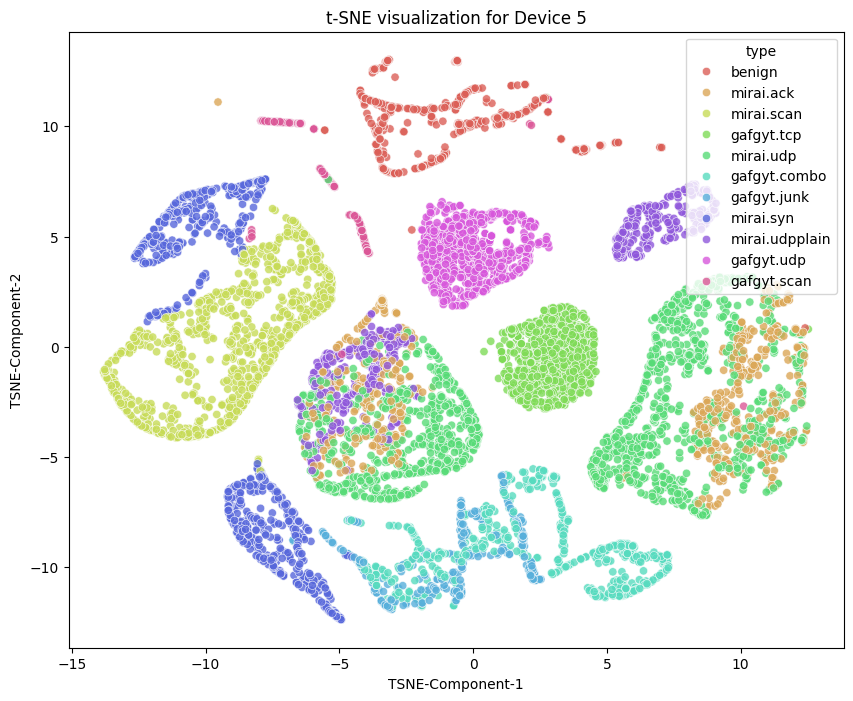

In [17]:
from sklearn.manifold import TSNE
import seaborn as sns

# Use the combined dataframe for device 5
# Assuming 'df' contains the data for device 5 as loaded previously
X_device = df.drop(columns=['type'])
y_device = df['type']

# Scale features for the single device data
scaler_device = StandardScaler()
X_scaled_device = scaler_device.fit_transform(X_device)

# Select a subset of the data for t-SNE
# Adjust the fraction or number of samples as needed based on computational resources
subset_size = 10000
if X_scaled_device.shape[0] > subset_size:
    np.random.seed(42) # for reproducibility
    subset_indices = np.random.choice(X_scaled_device.shape[0], subset_size, replace=False)
    X_subset = X_scaled_device[subset_indices]
    y_subset = y_device[subset_indices]
else:
    X_subset = X_scaled_device
    y_subset = y_device


# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
X_tsne = tsne.fit_transform(X_subset)


tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE-Component-1', 'TSNE-Component-2'])
tsne_df['type'] = y_subset.reset_index(drop=True)


plt.figure(figsize=(10, 8))
sea.scatterplot(
    x="TSNE-Component-1", y="TSNE-Component-2",
    hue="type",
    palette=sns.color_palette("hls", len(y_subset.unique())),
    data=tsne_df,
    legend="full",
    alpha=0.8
)
plt.title('t-SNE visualization for Device 5')
plt.show()

# Random Forest Model

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42
)

# Random Forest
rf = RandomForestClassifier(max_depth=10, n_estimators=200, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
#Accuracy Metric
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
#F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)
#Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.9531588309629021
F1 Score: 0.9525723241315279

Classification Report:
                 precision    recall  f1-score   support

        benign       1.00      1.00      1.00     18545
  gafgyt.combo       0.90      0.96      0.93     18337
   gafgyt.junk       0.91      0.78      0.84      9210
   gafgyt.scan       1.00      0.99      1.00      8826
    gafgyt.tcp       1.00      1.00      1.00     31493
    gafgyt.udp       1.00      1.00      1.00     31176
     mirai.ack       0.92      0.78      0.84     18109
    mirai.scan       0.97      1.00      0.98     29065
     mirai.syn       0.99      0.96      0.97     19763
     mirai.udp       0.93      0.95      0.94     46807
mirai.udpplain       0.83      0.91      0.87     17147

      accuracy                           0.95    248478
     macro avg       0.95      0.94      0.94    248478
  weighted avg       0.95      0.95      0.95    248478



In [19]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Train F1:", f1_score(y_train, y_pred_train, average='weighted'))
print("Test F1:", f1_score(y_test, y_pred_test, average='weighted'))

Train Accuracy: 0.9553211379449518
Test Accuracy: 0.9531588309629021
Train F1: 0.9548340103811396
Test F1: 0.9525723241315279


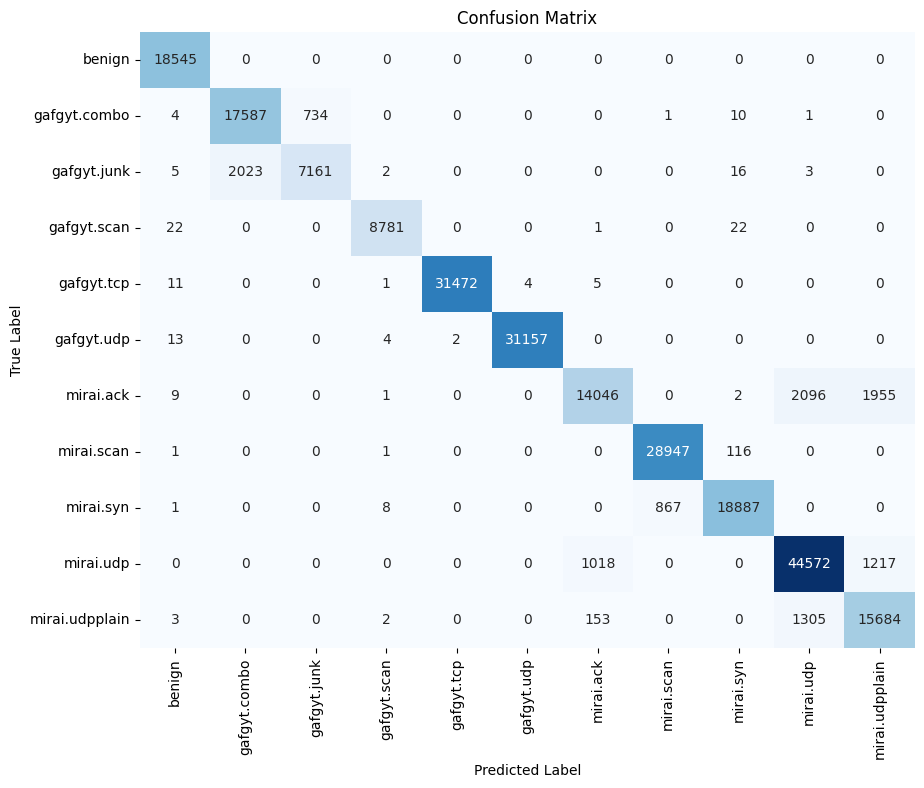

In [20]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Reasoning**:
Import the necessary libraries for the specified models and evaluation metrics.



In [21]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42
)

In [23]:
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [ ]:
y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)

f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
print("SVM F1 Score:", f1_svm)

cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(10, 8))
sea.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

xgb_model = XGBClassifier(random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train_encoded)

In [ ]:
y_pred_xgb = xgb_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

f1_xgb = f1_score(y_test_encoded, y_pred_xgb, average='weighted')
print("XGBoost F1 Score:", f1_xgb)

cm_xgb = confusion_matrix(y_test_encoded, y_pred_xgb)

plt.figure(figsize=(10, 8))
sea.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.show()

## Classification Reports


In [ ]:
# Print classification reports
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))


In [ ]:
print("\nXGBoost Classification Report:\n", classification_report(y_test_encoded, y_pred_xgb, target_names=label_encoder.classes_))

# Evaluation Metrics

In [ ]:
# Calculate ROC AUC for each model
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

def get_roc_auc(model, X_test, y_test_binarized):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        print(f"Model does not have predict_proba or decision_function.")
        return None

    # Calculate AUC for each class and then average (handling potential errors)
    roc_auc_scores = []
    for i in range(y_test_binarized.shape[1]):
        try:
            score = roc_auc_score(y_test_binarized[:, i], y_score[:, i])
            roc_auc_scores.append(score)
        except ValueError:
            # Handle cases where a class might have only one sample in y_test_binarized
            print(f"Could not calculate ROC AUC for class {lb.classes_[i]} due to insufficient samples.")
            roc_auc_scores.append(np.nan) # Append NaN for classes with errors

    # Calculate the weighted average AUC, ignoring NaNs
    return np.nanmean(roc_auc_scores) if roc_auc_scores else None

# Binarize the target variable
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)


roc_auc_rf = get_roc_auc(rf, X_test, y_test_binarized)
roc_auc_svm = get_roc_auc(svm_model, X_test, y_test_binarized)
roc_auc_xgb = get_roc_auc(xgb_model, X_test, y_test_binarized)


# Create a DataFrame to summarize all metrics
summary_metrics = {
    'Model': ['Random Forest', 'SVM', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, y_pred), accuracy_svm, accuracy_xgb],
    'F1 Score': [f1_score(y_test, y_pred, average='weighted'), f1_svm, f1_xgb],
    'ROC AUC': [roc_auc_rf, roc_auc_svm, roc_auc_xgb]
}

summary_df = pd.DataFrame(summary_metrics)

print("Summary of Evaluation Metrics:")
display(summary_df)

# Plotting all metrics together
summary_df_melted = summary_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sea.barplot(x='Model', y='Score', hue='Metric', data=summary_df_melted, palette='viridis')
plt.title('Comparison of Evaluation Metrics Across Models')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.show()